# Mouth Detection

**Importing Libraries**

In [20]:
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

**Exploring Dataset**

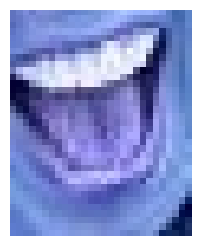

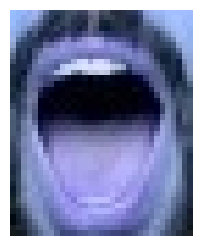

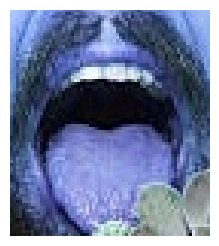

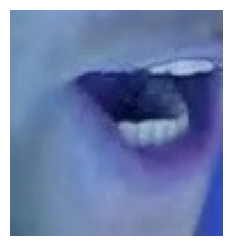

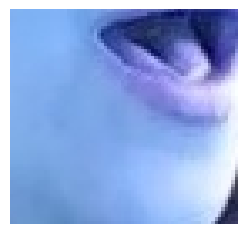

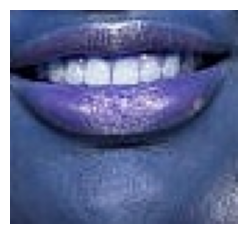

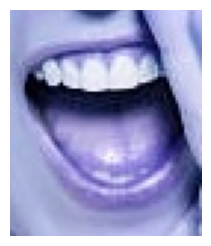

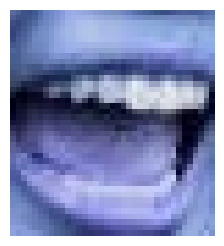

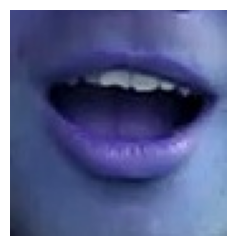

In [2]:
images = glob("train1/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(10, 10))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image))
    plt.axis('off')

**Preparing data for training**

In [3]:
img_size = 48
batch_size = 64

In [6]:
mouth_train_datagen = ImageDataGenerator()
mouth_train_generator = mouth_train_datagen.flow_from_directory("train1/",
                                                               target_size=(img_size, img_size),
                                                               color_mode="grayscale",
                                                               batch_size=batch_size,
                                                               class_mode="categorical",
                                                               shuffle=True)

mouth_validation_datagen = ImageDataGenerator()
mouth_validation_generator = mouth_validation_datagen.flow_from_directory("test1/",
                                                                         target_size=(img_size, img_size),
                                                                         color_mode="grayscale",
                                                                         batch_size=batch_size,
                                                                         class_mode="categorical",
                                                                         shuffle=True)


Found 2528 images belonging to 1 classes.
Found 2591 images belonging to 1 classes.


**Defining Model**

In [7]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    return x

In [8]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [13]:
def model_mouth_detection(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3, 3))
    conv_2 = Convolution(conv_1, 64, (5, 5))
    conv_3 = Convolution(conv_2, 128, (3, 3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten, 256)

    # Output for mouth detection (binary classification: open or closed)
    mouth_output = Dense(2, activation="softmax", name="mouth_output")(dense_1)

    model = Model(inputs=[inputs], outputs=[mouth_output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [14]:
model = model_mouth_detection((48, 48, 1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0     

**Training a model**

In [15]:
epochs = 15
steps_per_epoch = mouth_train_generator.n // mouth_train_generator.batch_size
validation_steps = mouth_validation_generator.n // mouth_validation_generator.batch_size
checkpoint = ModelCheckpoint("mouth_model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]

history = model.fit(
    x=mouth_train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=mouth_validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/15
39/39 [==============================] - ETA: 0s - loss: 1.7162 - accuracy: 0.5718
Epoch 1: saving model to mouth_model_weights.h5
39/39 [==============================] - 85s 2s/step - loss: 1.7162 - accuracy: 0.5718 - val_loss: 1.7833 - val_accuracy: 0.8016
Epoch 2/15
39/39 [==============================] - ETA: 0s - loss: 1.5781 - accuracy: 0.5726
Epoch 2: saving model to mouth_model_weights.h5
39/39 [==============================] - 21s 527ms/step - loss: 1.5781 - accuracy: 0.5726 - val_loss: 3.1822 - val_accuracy: 0.9711
Epoch 3/15
39/39 [==============================] - ETA: 0s - loss: 1.5847 - accuracy: 0.5783
Epoch 3: saving model to mouth_model_weights.h5
39/39 [==============================] - 20s 521ms/step - loss: 1.5847 - accuracy: 0.5783 - val_loss: 1.7093 - val_accuracy: 0.9496
Epoch 4/15
39/39 [==============================] - ETA: 0s - loss: 1.6169 - accuracy: 0.5593
Epoch 4: saving model to mouth_model_weights.h5
39/39 [==============================] 

**Model Evaluation**

In [16]:
model.evaluate(mouth_validation_generator)

41/41 [==============================] - 5s 113ms/step - loss: 1.3987 - accuracy: 0.3929


[1.398715615272522, 0.3928984999656677]

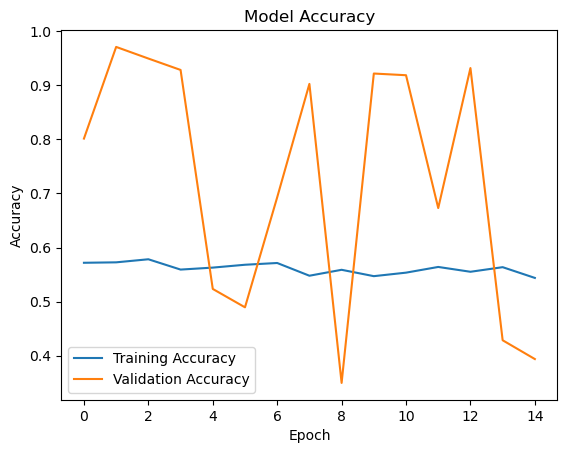

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Saving a Model**

In [19]:
model_json = model.to_json()
with open("mouth_model.json","w") as json_file:
    json_file.write(model_json)